In [79]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
plt.rcParams['figure.figsize'] = [17, 21]

In [80]:
# Constants
gamma = 5./3.
k_b = 1.380649e-16

In [81]:
# Setting grids
def setup_grid():
    global xmin, xmax, ng, nx, dx, dy, dz, Ax, Ay, dV, ilo, ihi
    global rho, P, e, T
    global u, w #, f_rho, f_e
    
    xmin = 0.
    xmax = 1.

    ng = 2 # ghost cells
    nx = 100 # number of cells
    dx = dy = (xmax - xmin)/nx
    dz = 1.
    Ax = dy*dz
    Ay = dx*dz
    dV = dx*dy*dz

    ilo = ng
    ihi = ng+nx#-1

    rho = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    P = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    e = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    T = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

    u = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    w = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

#    f_rho = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
#    f_e = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

In [105]:
def fill_ICs(type="1d shock"):
    global rho, P, e, T 
    global u, w#, f_rho, f_e
    
    if type == "1+1d shock": # 1+1d shock tube
        center = int(nx/2+ng)
        left = center - 10
        right = center + 10
        
        rho[ilo:ihi,ilo:ihi] = 0.1
        P[ilo:ihi,ilo:ihi] = 0.125
        
        rho[left:right,left:right] = 1.
        P[left:right,left:right] = 1.
    
    if type == "1d shock": # 1d shock tube
        center = int(nx/2+ng)
#        left = center - 10
#        right = center + 10
        
        rho[ilo:ihi,ilo:ihi] = 0.1
        P[ilo:ihi,ilo:ihi] = 0.125
        
        rho[:,ilo:center] = 1.
        P[:,ilo:center] = 1.
    
    else:
        print("unknown type")
        
    e = P/(gamma-1.)
    T = (gamma-1.)*(rho*dV*e)/k_b

In [111]:
def colormaps():
    plt.rcParams['figure.figsize'] = [17, 21]
    fig, axis = plt.subplots(3, 2)

    axis[0,0].pcolormesh(rho[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(rho), vmax=np.max(rho))
    axis[0,0].set_title('Density')
    fig.colorbar(axis[0,0].pcolormesh(rho[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(rho), vmax=np.max(rho)), ax=axis[0, 0])
    
    axis[0,1].pcolormesh(P[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(P), vmax=np.max(P))
    axis[0,1].set_title('Pressure')
    fig.colorbar(axis[0,1].pcolormesh(P[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(P), vmax=np.max(P)), ax=axis[0, 1])
    
    axis[1,0].pcolormesh(e[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(e), vmax=np.max(e))
    axis[1,0].set_title('Energy')
    fig.colorbar(axis[1,0].pcolormesh(e[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(e), vmax=np.max(e)), ax=axis[1, 0])
    
    axis[1,1].pcolormesh(T[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(T), vmax=np.max(T))
    axis[1,1].set_title('Temperature')
    fig.colorbar(axis[1,1].pcolormesh(T[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(T), vmax=np.max(T)), ax=axis[1, 1])
    
    axis[2,0].pcolormesh(u[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(u), vmax=np.max(u))
    axis[2,0].set_title('x velocity')
    fig.colorbar(axis[2,0].pcolormesh(u[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(u), vmax=np.max(u)), ax=axis[2, 0])
                 
    axis[2,1].pcolormesh(w[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(w), vmax=np.max(w))
    axis[2,1].set_title('y velocity')
    fig.colorbar(axis[2,1].pcolormesh(w[ilo:ihi,ilo:ihi], cmap=plt.cm.jet, vmin=np.min(w), vmax=np.max(w)), ax=axis[2, 1])

In [84]:
def apply_BCs(apply):
    for var_array in [apply]:
        # periodic boundary condition for horizontal
        var_array[:,ilo-2] = var_array[:,ihi-1]
        var_array[:,ilo-1] = var_array[:,ihi-2]
        var_array[:,ihi+1] = var_array[:,ilo]
        var_array[:,ihi] = var_array[:,ilo+1]
        
        # reflecting boundary condition for vertical
        var_array[ilo-2,:] = var_array[ilo+1,:]
        var_array[ilo-1,:] = var_array[ilo,:]
        var_array[ihi,:] = var_array[ihi-1,:]
        var_array[ihi+1,:] = var_array[ihi-2,:]

In [85]:
def timestep():
    global dt, q

    du = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    dw = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            du[k,j] = u[k,j+1] - u[k,j]
            dw[k,j] = w[k,j+1] - w[k,j]
    apply_BCs(du)
    apply_BCs(dw)
            
    q = 1. # must be equal to the viscosity parameter
    cs = np.sqrt(gamma*P/rho)
    C0 = 0.5
    dt_1 = dx/(cs+np.abs(u)) #1/cs*np.min(dx,dy)
    dt_2 = dy/(cs+np.abs(w)) #dx/np.abs(u)
    dt_3 = dx/(4.*q*q*np.abs(du)) #dy/np.abs(w)
    dt_4 = dy/(4.*q*q*np.abs(dw)) #np.min(dx/(4.q*q*np.abs(du)),dy/(4.q*q*np.abs(dw)))
    dt = C0*min(np.min(dt_1),np.min(dt_2),np.min(dt_3),np.min(dt_4))
    # dt = C0*np.max(dt_1**(-2.0)+dt_2**(-2.0)+dt_3**(-2.0)+dt_4**(-2.0))**(-0.5)

In [86]:
def solve_source():

    def s_update_velocity(): # Eq.(6.70)
        global u, w
    #    u_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    #    w_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

        for k in range(ilo,ihi):
            for j in range(ilo,ihi):
    #            u_temp[k,j] = u[k,j] - 2.0*dt*(P[k,j+1]-P[k,j-1])/(dx*(rho[k,j]+rho[k,j-1]))
    #            w_temp[k,j] = w[k,j] - 2.0*dt*(P[k+1,j]-P[k-1,j])/(dy*(rho[k,j]+rho[k-1,j]))
                u[k,j] -= 2.*dt*(P[k,j]-P[k,j-1])/(dx*(rho[k,j]+rho[k,j-1]))
                w[k,j] -= 2.*dt*(P[k,j]-P[k-1,j])/(dy*(rho[k,j]+rho[k-1,j]))

        apply_BCs(u)
        apply_BCs(w)
    #    u = u_temp
    #    w = w_temp

    def s_update_energy():
        global P, e, T
    #    global P_temp_p, P_temp_half, e_temp

        e_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    #    e_temp_p = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
        P_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
        P_half = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

        for k in range(ilo,ihi):
            for j in range(ilo,ihi):        
                e_temp[k,j] = e[k,j] - dt*P[k,j]*((u[k,j+1]-u[k,j])/dx + (w[k+1,j]-w[k,j])/dy)
                P_temp[k,j] = e_temp[k,j]/(gamma-1.)
                P_half[k,j] = 0.5*(P[k,j] + P_temp[k,j])
                #e[k,j] = e[k,j] - dt*P_half[k,j]*((u[k,j+1]-u[k,j])/dx + (w[k+1,j]-w[k,j])/dy)
                e[k,j] -= dt*P_half[k,j]*((u[k,j+1]-u[k,j])/dx + (w[k+1,j]-w[k,j])/dy)
                P[k,j] = e[k,j]*(gamma-1.)
                T[k,j] = (gamma-1.)*(rho[k,j]*dV*e[k,j])/k_b

        apply_BCs(e)
        apply_BCs(P)
        apply_BCs(T)
        

    def s_apply_artificial_viscosity():
        global u, w, e

    #    u_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    #    w_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    #    e_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

        def obtain_Q():
            global Qx, Qy

            Qx = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
            Qy = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

            for k in range(ilo,ihi):
                for j in range(ilo,ihi):
                    if u[k,j+1]-u[k,j] < 0.:
                        Qx[k,j] = q**2.*rho[k,j]*(u[k,j+1]-u[k,j])**2.
                    else:
                        Qx[k,j] = 0.

            for k in range(ilo,ihi):
                for j in range(ilo,ihi):
                    if w[k+1,j]-w[k,j] < 0.:
                        Qy[k,j] = q**2.*rho[k,j]*(w[k+1,j]-w[k,j])**2.
                    else:
                        Qy[k,j] =  0.

        obtain_Q()
        apply_BCs(Qx)
        apply_BCs(Qy)

        for k in range(ilo,ihi):
            for j in range(ilo,ihi):
                u[k,j] -= 2.*dt*(Qx[k,j]-Qx[k,j-1])/(dx*(rho[k,j]+rho[k,j-1]))
                w[k,j] -= 2.*dt*(Qy[k,j]-Qy[k-1,j])/(dy*(rho[k,j]+rho[k-1,j]))
                e[k,j] -= dt*(Qx[k,j]*(u[k,j+1]-u[k,j])/dx + Qy[k,j]*(w[k+1,j]-w[k,j])/dy)
    #            u_temp[k,j] = u[k,j] - 2*dt*(Qx[k,j+1]-Qx[k,j-1])/(dx*(rho[k,j]+rho[k,j-1]))
    #            w_temp[k,j] = w[k,j] - 2*dt*(Qy[k+1,j]-Qy[k-1,j])/(dy*(rho[k,j]+rho[k-1,j]))
    #            e_temp[k,j] = e[k,j] - dt*Qx[k,j]*(u[k,j+1]-u[k,j])/dx + Qy[k,j]*(w[k+1,j]-w[k,j])/dy

        apply_BCs(u)
        apply_BCs(w)
        apply_BCs(e)
    #    u = u_temp
    #    w = w_temp
    #    e = e_temp
    s_update_velocity()
    s_update_energy()
    s_apply_artificial_viscosity()

/var/folders/3x/30r4ysj529q8y2tqtkxxfj140000gp/T/ipykernel_18732/1438931870.py:19: RuntimeWarning: divide by zero encountered in true_divide
  dt_3 = dx/(4.*q*q*np.abs(du)) #dy/np.abs(w)
/var/folders/3x/30r4ysj529q8y2tqtkxxfj140000gp/T/ipykernel_18732/1438931870.py:20: RuntimeWarning: divide by zero encountered in true_divide
  dt_4 = dy/(4.*q*q*np.abs(dw)) #np.min(dx/(4.q*q*np.abs(du)),dy/(4.q*q*np.abs(dw)))


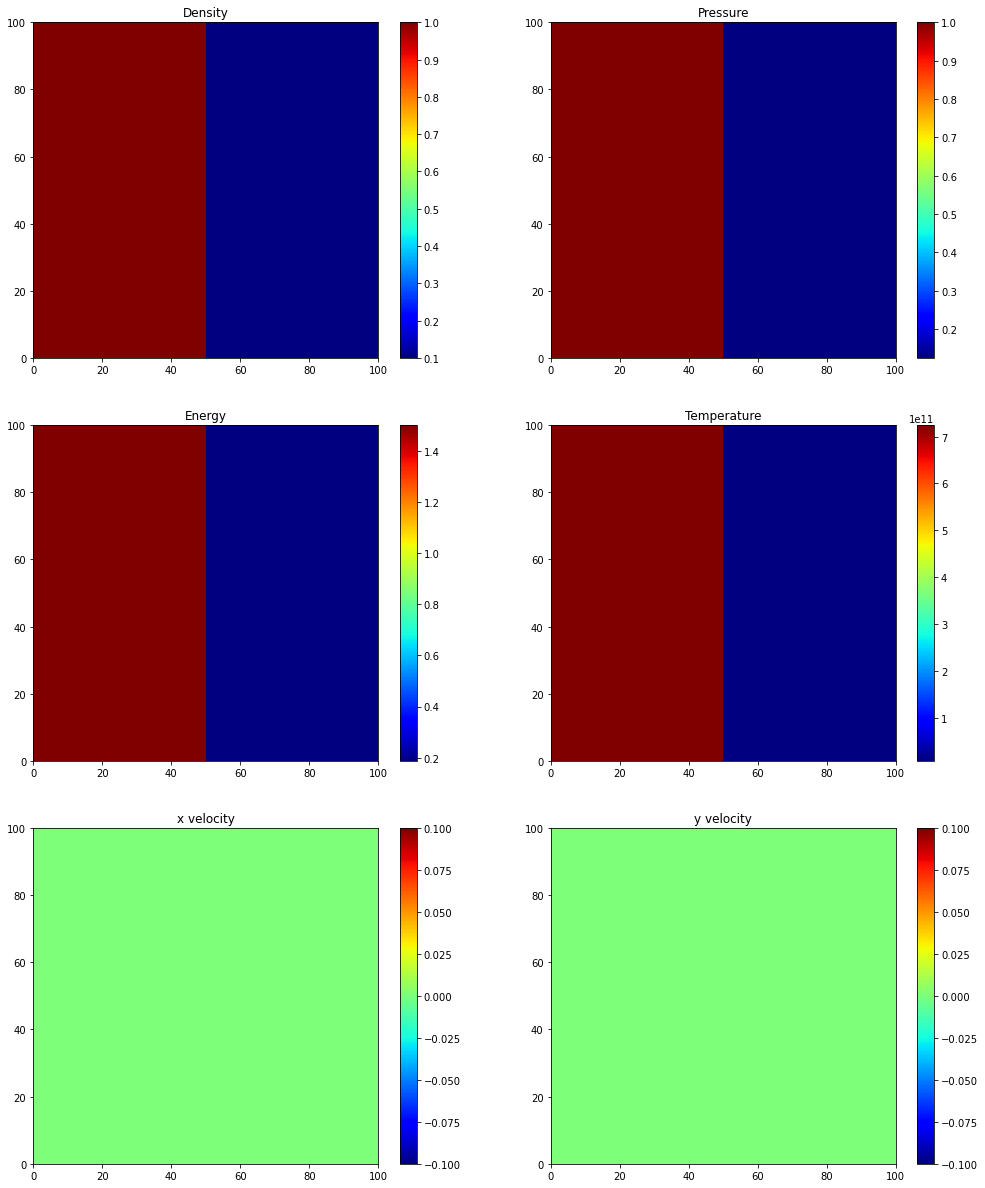

In [112]:
setup_grid()
fill_ICs(type="1d shock")

total = [rho, P, e, T, u, w]
for var in total:
    apply_BCs(var)

for i in range(1):
    
    timestep()

#    solve_source()
#update_velocity()
#update_energy()
#apply_artificial_viscosity()


#solve_advection()
colormaps()
#timestep()
#print(dt)

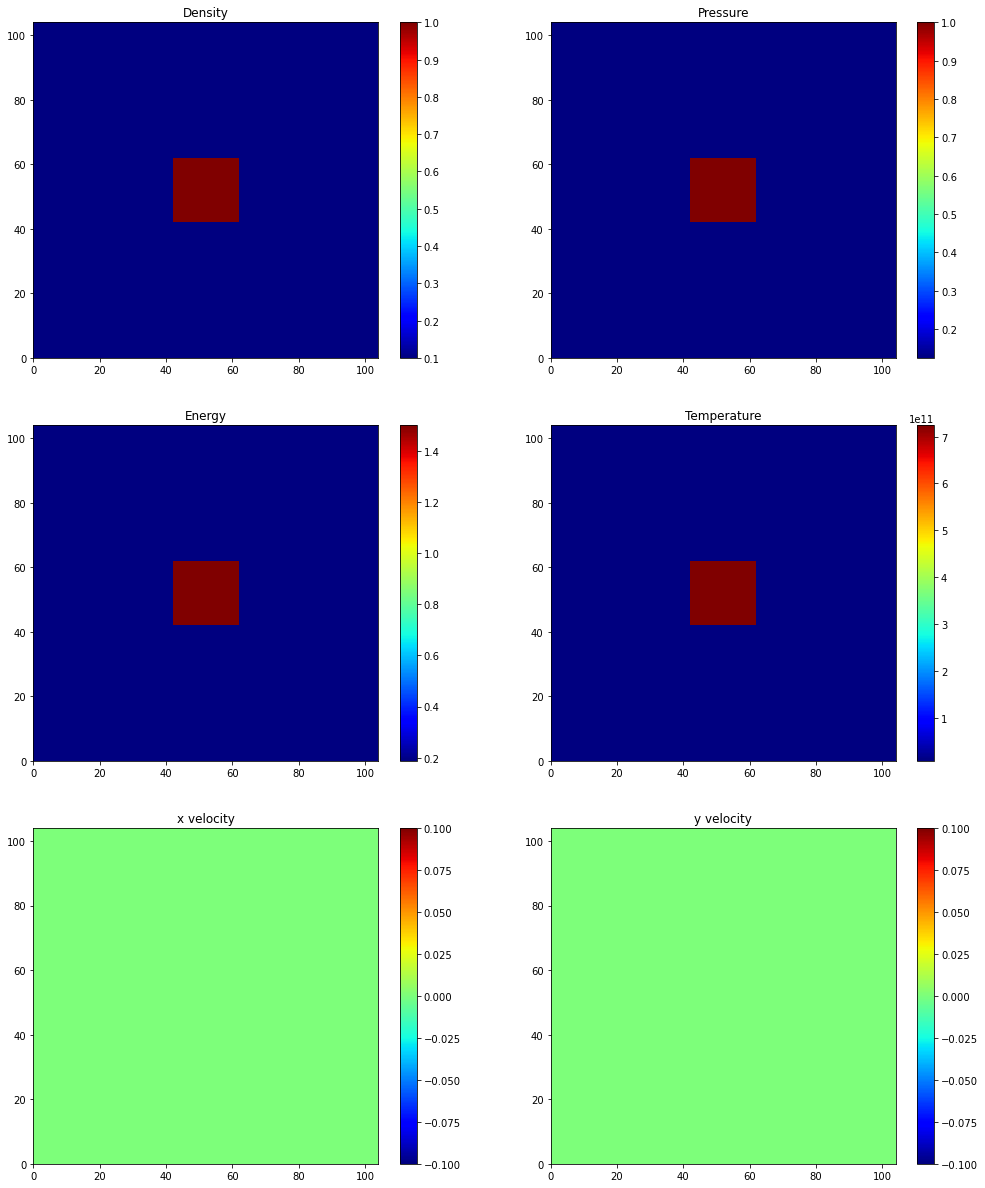

In [88]:
def ad_obtain_avg(method="donor"):
    global avg_rho_x, avg_rho_y, avg_e_x, avg_e_y
    global avg_u_x, avg_u_y, avg_w_x, avg_w_y
    
    avg_rho_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    avg_rho_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    avg_e_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    avg_e_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    avg_u_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    avg_u_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    avg_w_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    avg_w_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)    
    
    if method == "donor": # use this for now
        for k in range(ilo,ihi):
            for j in range(ilo,ihi):
                if u[k,j] >= 0.: 
                    avg_rho_x[k,j] = 0.5*(rho[k,j]+rho[k,j-1])
                    avg_e_x[k,j] = 0.5*(e[k,j]+e[k,j-1])/avg_rho_x[k,j]
                else: # u[k,j] < 0.:
                    avg_rho_x[k,j] = 0.5*(rho[k,j+1]+rho[k,j])
                    avg_e_x[k,j] = 0.5*(e[k,j+1]+e[k,j])/avg_rho_x[k,j]
                    
                if w[k,j] >= 0.:
                    avg_rho_y[k,j] = 0.5*(rho[k,j]+rho[k-1,j])
                    avg_e_y[k,j] = 0.5*(e[k,j]+e[k-1,j])/avg_rho_y[k,j]
                else:
                    avg_rho_y[k,j] = 0.5*(rho[k+1,j]+rho[k,j])
                    avg_e_y[k,j] = 0.5*(e[k+1,j]+e[k,j])/avg_rho_y[k,j]
                    
                if 0.5*(u[k,j]+u[k,j-1]) <= 0.:
                    avg_u_x[k,j] = u[k,j]
                    avg_w_x[k,j] = w[k,j]
                else:
                    avg_u_x[k,j] = u[k,j-1]
                    avg_w_x[k,j] = w[k,j-1]
                    
                if 0.5*(w[k,j]+w[k-1,j]) <= 0.:
                    avg_u_y[k,j] = u[k,j]
                    avg_w_y[k,j] = w[k,j]
                else:
                    avg_u_y[k,j] = u[k-1,j]
                    avg_w_y[k,j] = w[k-1,j]
                       
    elif method == "van Leer":
        print("Sorry, under development!")
    else:
        print("Again, under development!")
    
    total = [avg_rho_x, avg_rho_y, avg_e_x, avg_e_y, avg_u_x, avg_u_y, avg_w_x, avg_w_y]
    for var in total:
        apply_BCs(var)
        
ad_obtain_avg(method="donor")
#print(np.max(avg_u_y))
colormaps()

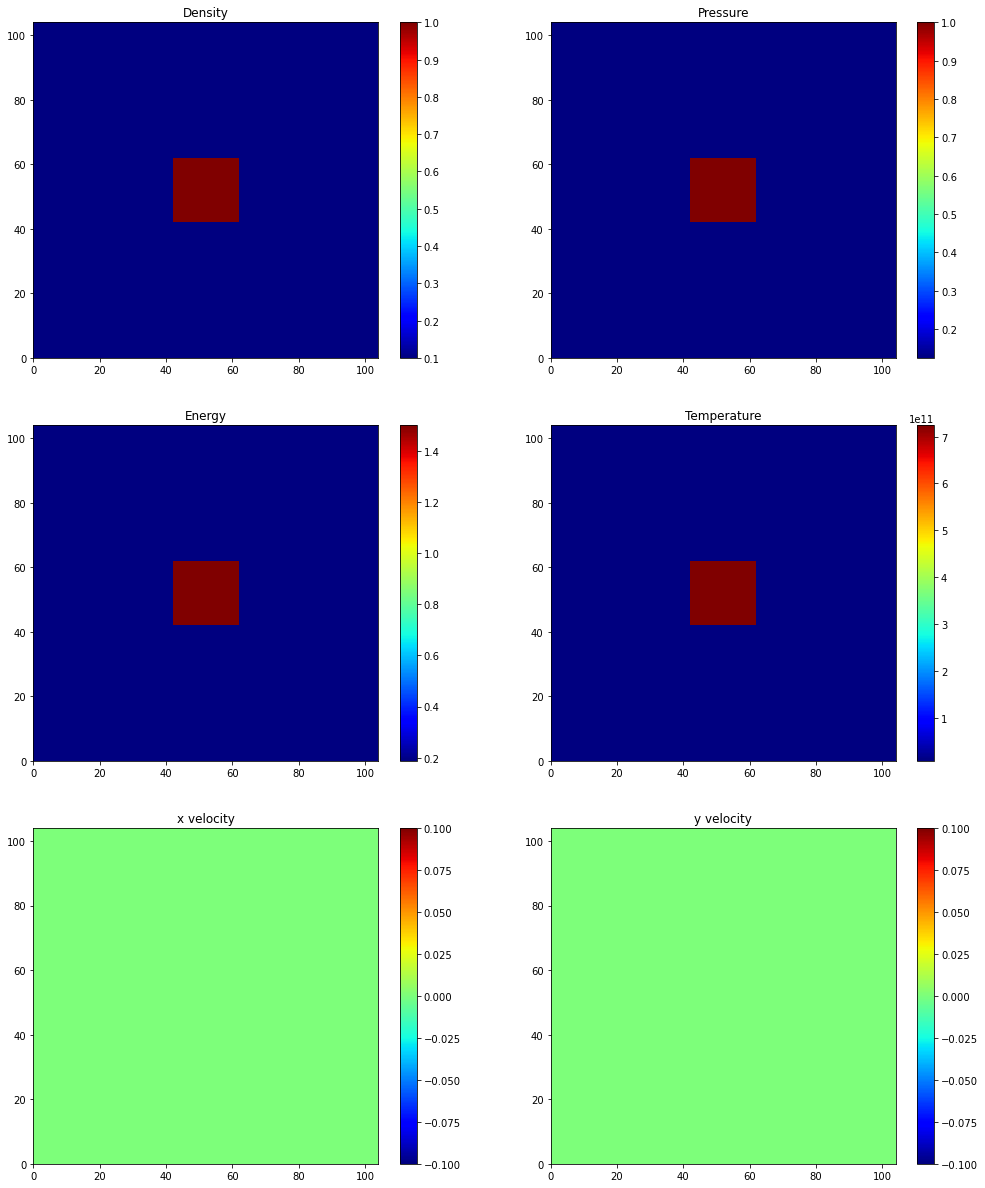

In [89]:
def ad_update_density():
    global rho, f_rho_x, f_rho_y
    
    f_rho_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_rho_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)    
    
    # density flux
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            f_rho_x[k,j] = u[k,j]*avg_rho_x[k,j]*Ax
            f_rho_y[k,j] = w[k,j]*avg_rho_y[k,j]*Ay

    apply_BCs(f_rho_x)
    apply_BCs(f_rho_y)

    # density calculation
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):            
            rho[k,j] -= dt/dV*(f_rho_x[k,j+1]-f_rho_x[k,j])
            rho[k,j] -= dt/dV*(f_rho_y[k+1,j]-f_rho_y[k,j])

    apply_BCs(rho)
    
ad_update_density()
colormaps()

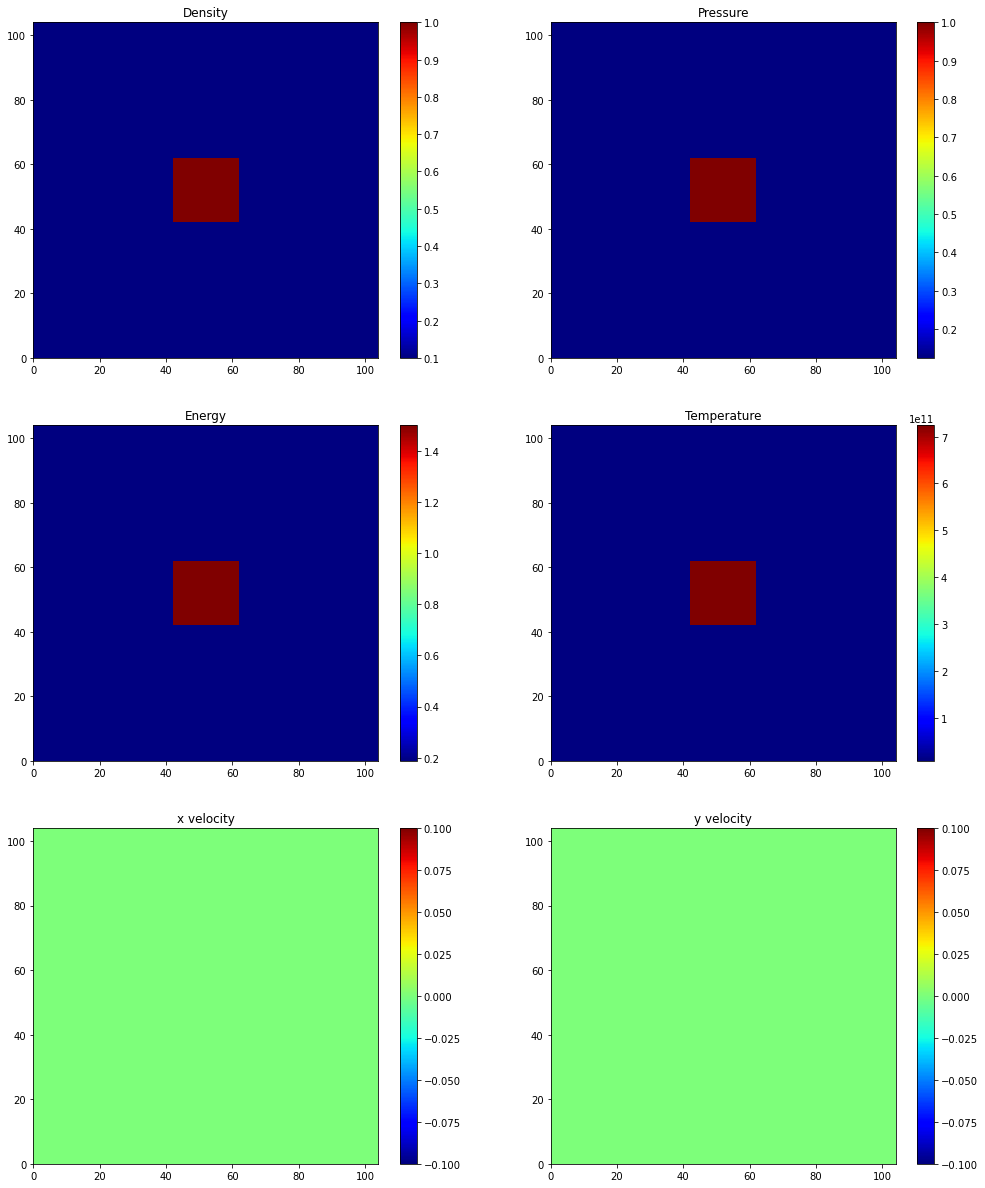

In [90]:
def ad_update_energy():
    global e, f_e_x, f_e_y
    
    f_e_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_e_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

    # energy flux
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):            
            f_e_x[k,j] = avg_e_x[k,j]*f_rho_x[k,j]
            f_e_y[k,j] = avg_e_y[k,j]*f_rho_y[k,j]

    apply_BCs(f_e_x)
    apply_BCs(f_e_y)
    
    # energy calculation
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            e[k,j] -= dt/dV*(f_e_x[k,j+1]-f_e_x[k,j])
            e[k,j] -= dt/dV*(f_e_y[k+1,j]-f_e_y[k,j])
    
    apply_BCs(e)

ad_update_energy()
colormaps()    

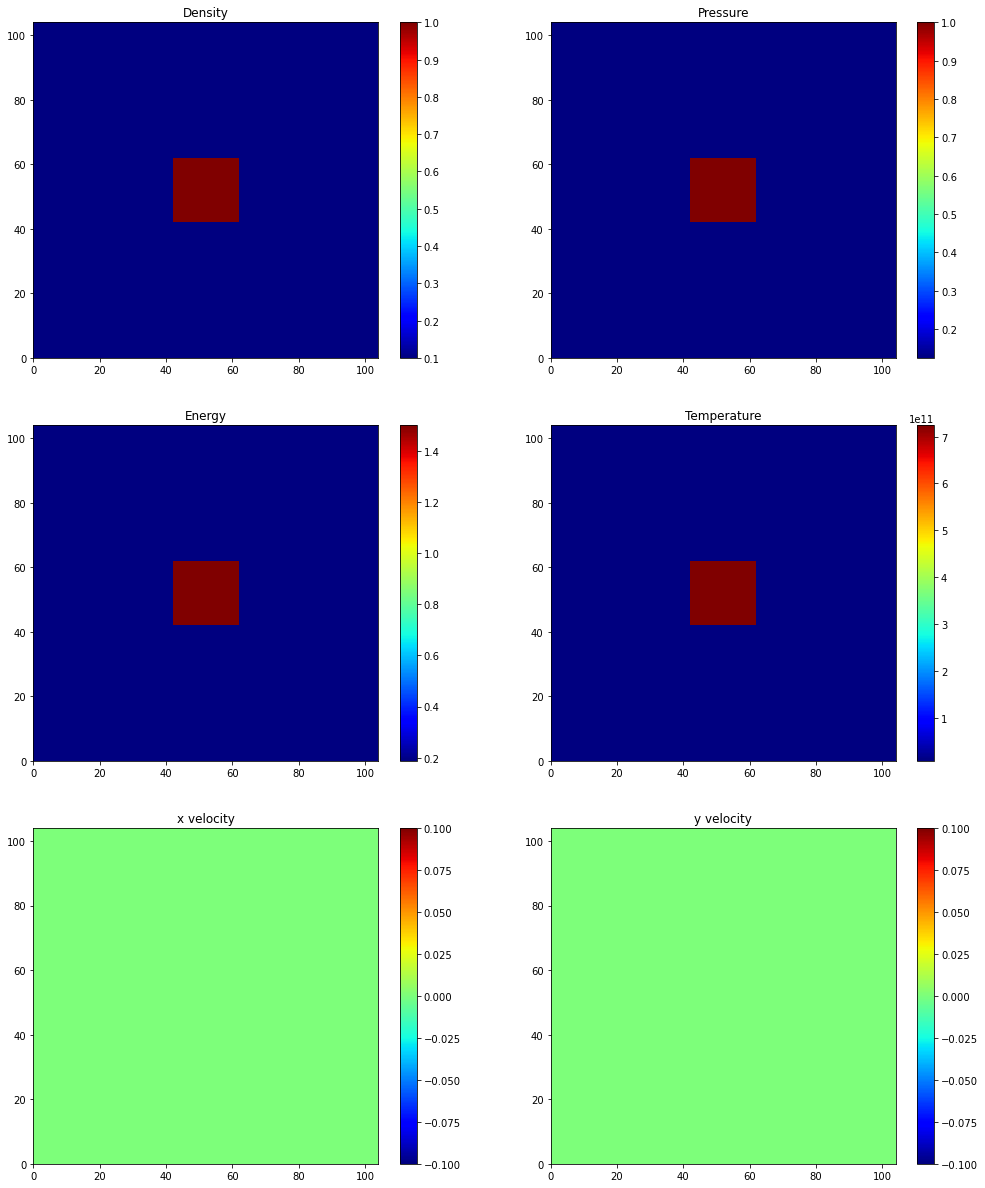

In [91]:
def ad_get_momentum():
    global f_u_x, f_u_y, f_w_x, f_w_y
    
    f_u_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_u_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_w_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_w_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            f_u_x[k,j] = avg_u_x[k,j]*0.5*(f_rho_x[k,j-1]+f_rho_x[k,j])
            f_u_y[k,j] = avg_u_y[k,j]*0.5*(f_rho_y[k,j-1]+f_rho_y[k,j])
            f_w_x[k,j] = avg_w_x[k,j]*0.5*(f_rho_x[k-1,j]+f_rho_x[k,j])
            f_w_y[k,j] = avg_w_y[k,j]*0.5*(f_rho_y[k-1,j]+f_rho_y[k,j])

    apply_BCs(f_u_x)
    apply_BCs(f_u_y)            
    apply_BCs(f_w_x)            
    apply_BCs(f_w_y)

ad_get_momentum()
colormaps()

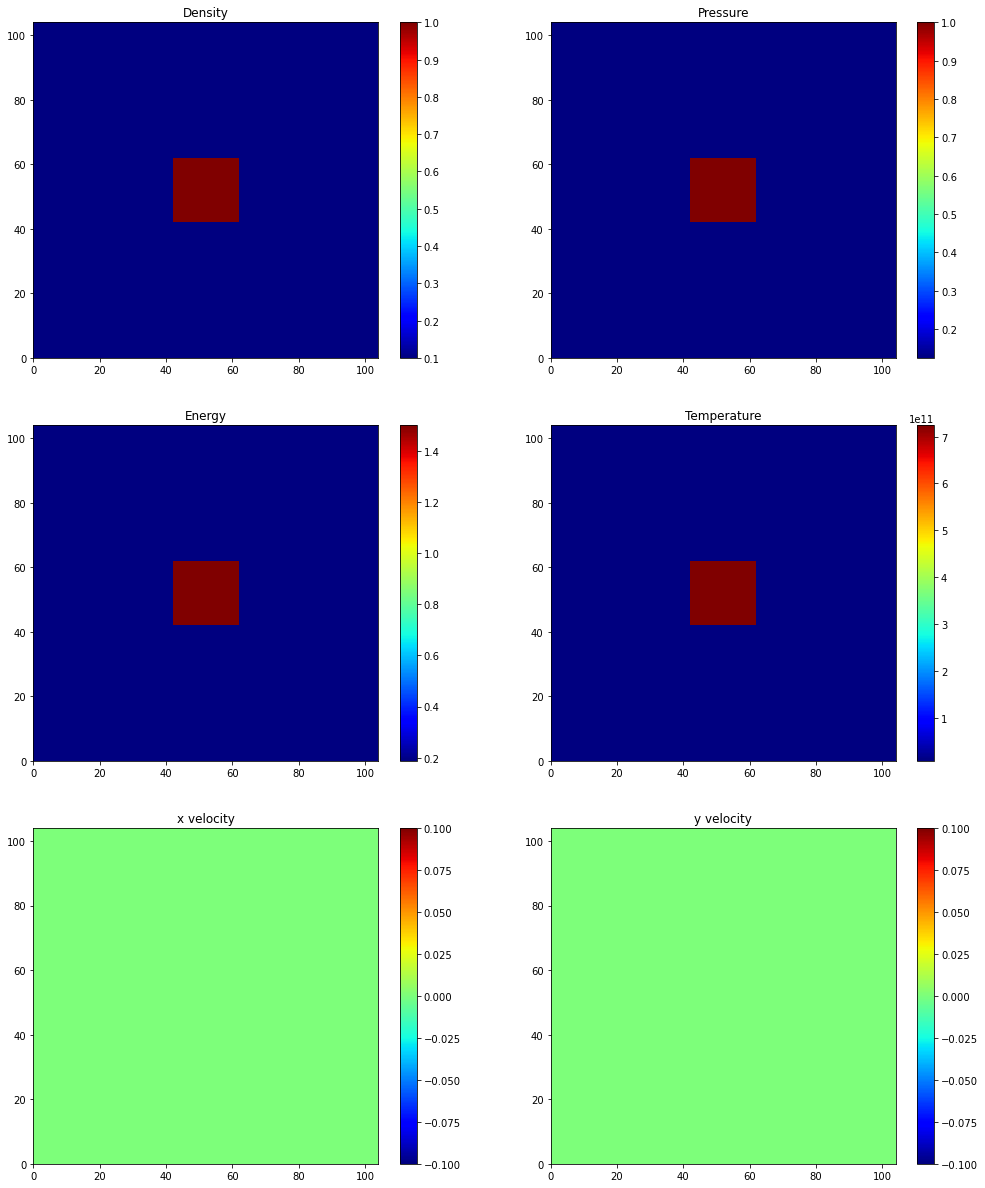

In [92]:
def ad_update_momentum():
    global mom_den_u, mom_den_w
    
    mom_den_u = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    mom_den_w = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    # momentum-density
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            mom_den_u[k,j] = rho[k,j]*u[k,j]
            mom_den_w[k,j] = rho[k,j]*w[k,j]
                
    apply_BCs(mom_den_u)
    apply_BCs(mom_den_w)
    
    # momentum-density update
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):            
            mom_den_u[k,j] -= dt/dV*(f_u_x[k,j+1]-f_u_x[k,j])
            mom_den_u[k,j] -= dt/dV*(f_u_y[k+1,j]-f_u_y[k,j])

            mom_den_w[k,j] -= dt/dV*(f_w_x[k,j+1]-f_w_x[k,j])
            mom_den_w[k,j] -= dt/dV*(f_w_y[k+1,j]-f_w_y[k,j])

    apply_BCs(mom_den_u)
    apply_BCs(mom_den_w)
    
ad_update_momentum()
colormaps()
#print(mom_den_u)

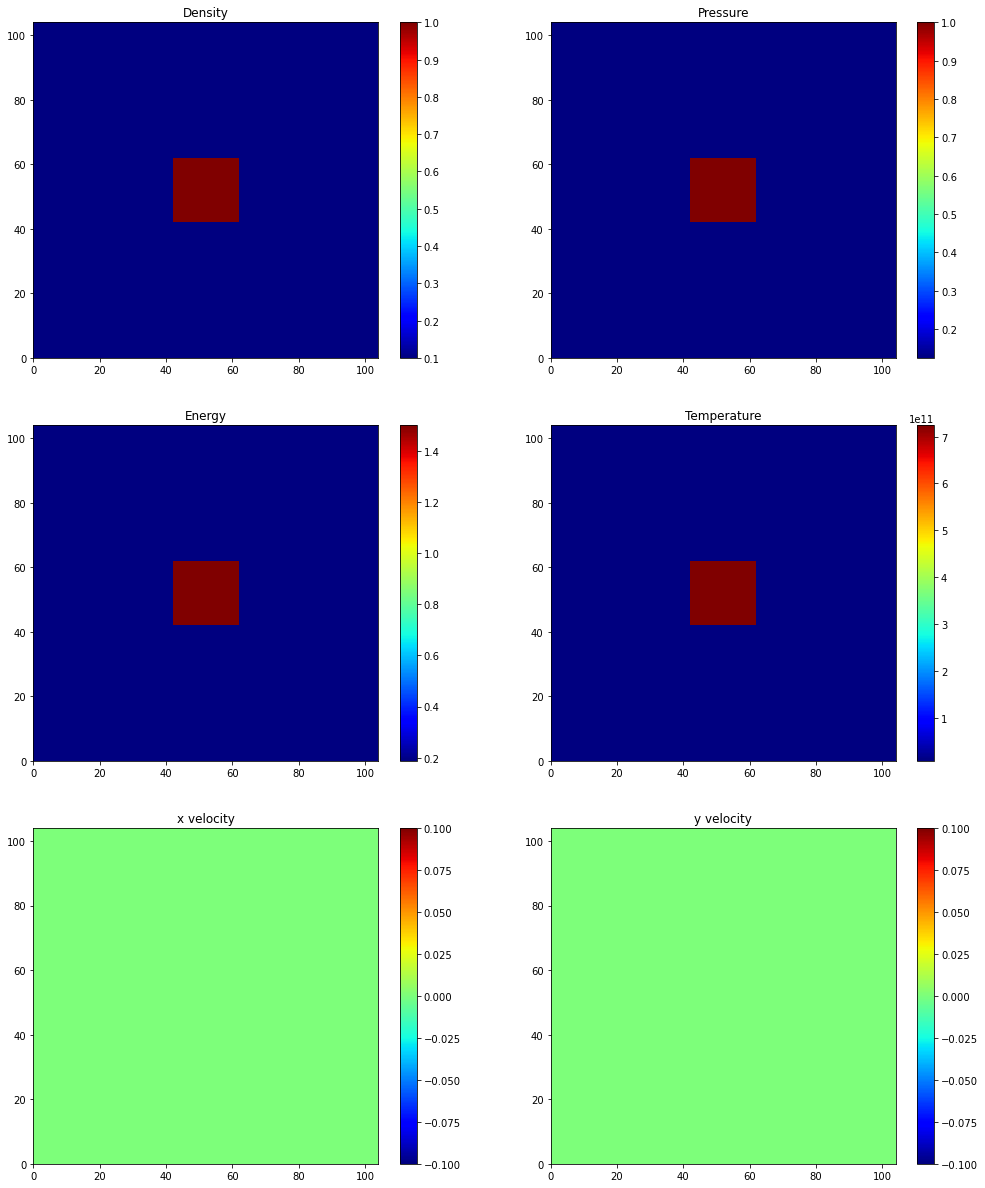

In [93]:
def ad_update_velocity():
    global u, w
#    global mon_den_u, mon_den_w
    
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            u[k,j] = mom_den_u[k,j]/rho[k,j] #(0.5*(rho[k,j]+rho[k,j+1])) #rho[k,j]
            w[k,j] = mom_den_w[k,j]/rho[k,j] #(0.5*(rho[k,j]+rho[k+1,j]))
            
    apply_BCs(u)
    apply_BCs(w)

ad_update_velocity()
colormaps()

In [94]:
def ad_update_temperature():
    global T
    
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):    
            T[k,j] = (gamma-1.)*(rho[k,j]*dV*e[k,j])/k_b
    apply_BCs(T)

In [120]:
def solve_advection():
#    global rho, e, P, T
#    global u, w, mom_den_u, mom_den_w

#    def obtain_avg(method="donor"):
        #put it later


    ad_obtain_avg()
    
    # density flux
    ad_update_density()

    # energy flux
    ad_update_energy()
    
    # momentum-density
    ad_get_momentum()
    
    # momentum-density update
    ad_update_momentum()
    
    # update velocity
    ad_update_velocity()
    
    ad_update_temperature()

## Main program

/var/folders/3x/30r4ysj529q8y2tqtkxxfj140000gp/T/ipykernel_18732/1438931870.py:19: RuntimeWarning: divide by zero encountered in true_divide
  dt_3 = dx/(4.*q*q*np.abs(du)) #dy/np.abs(w)
/var/folders/3x/30r4ysj529q8y2tqtkxxfj140000gp/T/ipykernel_18732/1438931870.py:20: RuntimeWarning: divide by zero encountered in true_divide
  dt_4 = dy/(4.*q*q*np.abs(dw)) #np.min(dx/(4.q*q*np.abs(du)),dy/(4.q*q*np.abs(dw)))


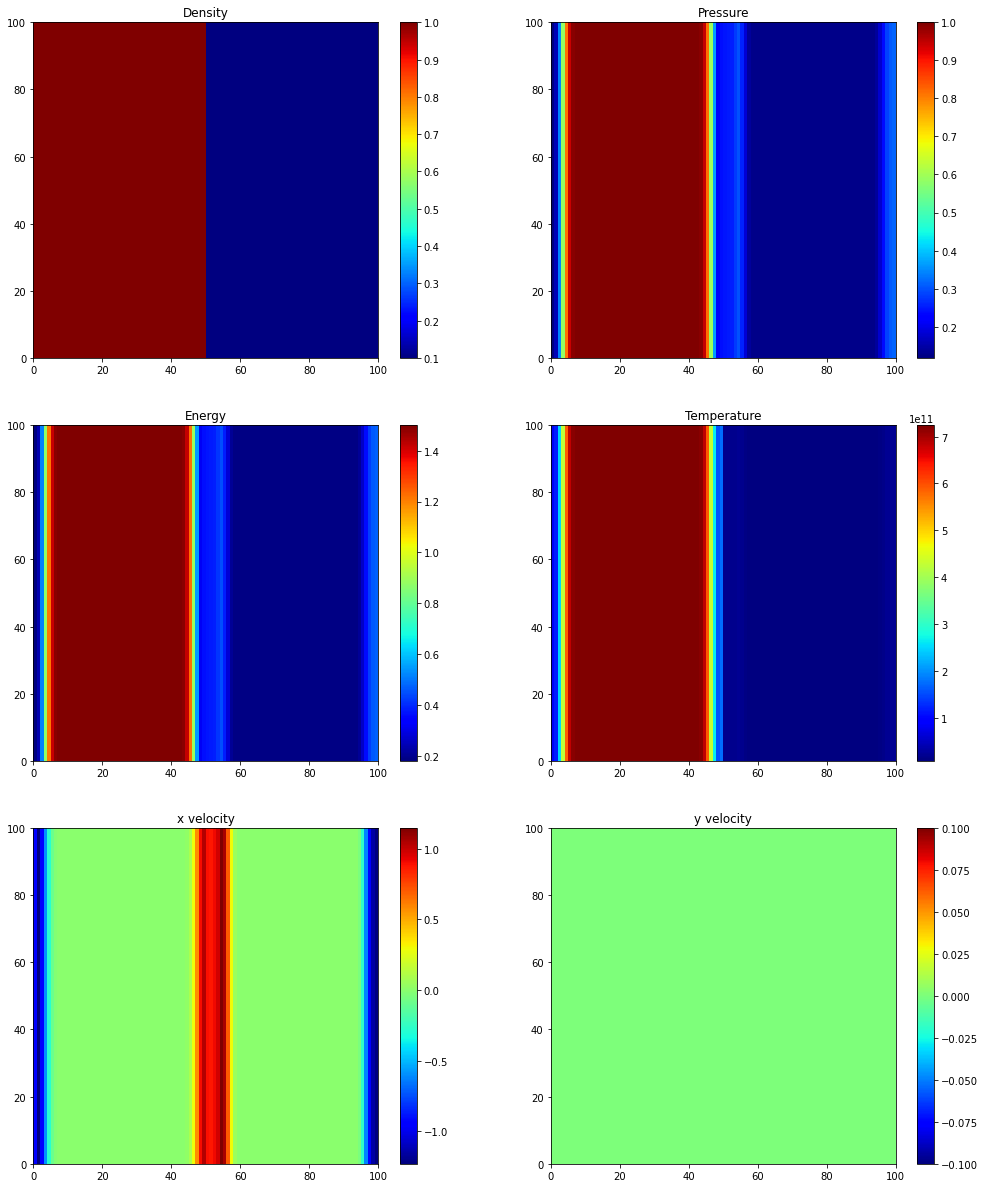

In [126]:
setup_grid()
fill_ICs(type="1d shock")

total = [rho, P, e, T, u, w]
for var in total:
    apply_BCs(var)

for i in range(30):    
    
    timestep()
    solve_source()
    #update_velocity()
    #update_energy()
    #apply_artificial_viscosity()

#    solve_advection()
#    ad_obtain_avg()
#    ad_update_density()

colormaps()

# setup the grid

# solve advection
## set dt
## set fill_IC
### while loop t < tmax
#### apply_BCs
#### calculating source
#### apply BCs
##### solve advection
### do again

## check the avergage
## sound speed

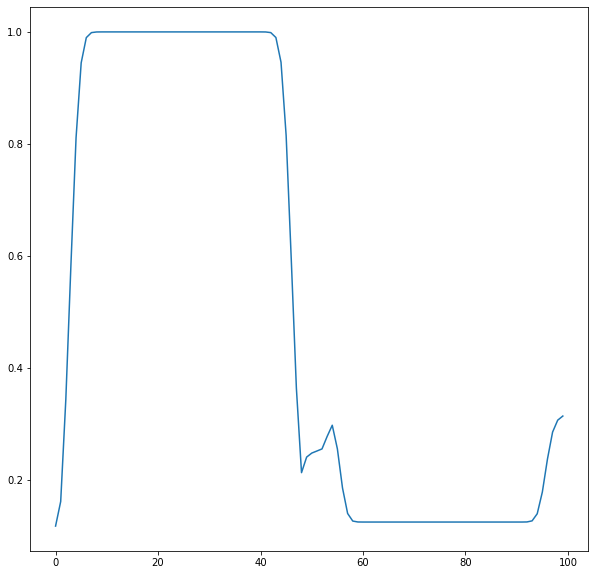

In [127]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(P[52,ilo:ihi])


## Implementing other's code to test animation

In [38]:
# We use numpy (for array related operations) and matplotlib (for plotting) 
# because they will help us a lot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

plate_length = 50
max_iter_time = 1000

alpha = 2.0
delta_x = 1

# Calculated params
delta_t = (delta_x ** 2)/(4 * alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)

# Initialize solution: the grid of u(k, i, j)
u = np.empty((max_iter_time, plate_length, plate_length))

# Initial condition everywhere inside the grid
u_initial = 0.0

# Boundary conditions (fixed temperature)
u_top = 100.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0

# Set the initial condition
u.fill(u_initial)

# Set the boundary conditions
u[:, (plate_length-1):, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (plate_length-1):] = u_right

In [39]:
def calculate(u):
  for k in range(0, max_iter_time-1, 1):
    for i in range(1, plate_length-1, delta_x):
      for j in range(1, plate_length-1, delta_x):
        u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]
  
  return u

In [40]:
def plotheatmap(u_k, k):
  # Clear the current plot figure
  plt.clf()
  plt.title(f"Temperature at t = {k*delta_t:.3f} unit time")
  plt.xlabel("x")
  plt.ylabel("y")
  
  # This is to plot u_k (u at time-step k)
  plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=100)
  plt.colorbar()
  
  return plt

In [41]:
def animate(k):
  plotheatmap(u[k], k)

anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False)
#anim.save("heat_equation_solution.gif")

<Figure size 720x720 with 0 Axes>

2D heat equation solver


/Users/avm4/opt/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


Done!


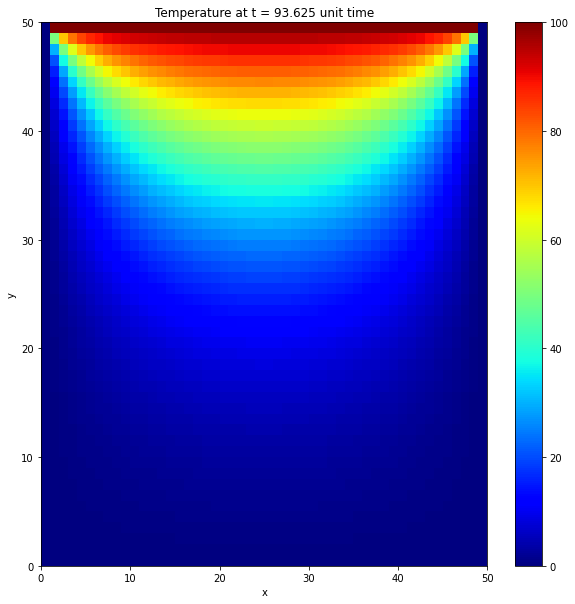

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

print("2D heat equation solver")

plate_length = 50
max_iter_time = 750

alpha = 2
delta_x = 1

delta_t = (delta_x ** 2)/(4 * alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)

# Initialize solution: the grid of u(k, i, j)
u = np.empty((max_iter_time, plate_length, plate_length))

# Initial condition everywhere inside the grid
u_initial = 0

# Boundary conditions
u_top = 100.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0

# Set the initial condition
u.fill(u_initial)

# Set the boundary conditions
u[:, (plate_length-1):, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (plate_length-1):] = u_right

def calculate(u):
    for k in range(0, max_iter_time-1, 1):
        for i in range(1, plate_length-1, delta_x):
            for j in range(1, plate_length-1, delta_x):
                u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]

    return u

def plotheatmap(u_k, k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Temperature at t = {k*delta_t:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=100)
    plt.colorbar()

    return plt

# Do the calculation here
u = calculate(u)

def animate(k):
    plotheatmap(u[k], k)

anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False)
anim.save("heat_equation_solution.gif")#,writer='Pillow', fps=2)

print("Done!")